In [1]:
import xarray as xr
import pandas as pd
import os
import numpy as np
import deepsensor
import cartopy.crs as ccrs
import deepsensor.torch
import matplotlib.pyplot as plt
from deepsensor.model import ConvNP
from tqdm import tqdm_notebook
from deepsensor.data import DataProcessor, TaskLoader
from deepsensor.train import set_gpu_default_device, Trainer

In [2]:
set_gpu_default_device()

#### Reading data files and merging them to form an xarray ds

In [3]:
def extract_timestamp(file):
    return np.datetime64(f'{file[-9:-5]}-{file[-5:-3]}-01 00:00:00.000000000','ns')

combined_ds = []
dir_path = 'Monthly/Monthly'
for file in os.listdir(dir_path):
    monthly_ds = xr.open_dataset(os.path.join(dir_path,file))
    timestamp = extract_timestamp(file)
    combined_ds.append(monthly_ds.expand_dims({'Timestamp':[timestamp]}))
wustl_monthly_ds = xr.concat(combined_ds,dim='Timestamp').sortby('Timestamp')

# wustl = wustl_monthly_ds.sel(Timestamp = slice("2021-01-01","2023-12-31"))

In [4]:
wustl = wustl_monthly_ds.copy()
wustl

<xarray.Dataset> Size: 2GB
Dimensions:    (Timestamp: 312, lat: 1100, lon: 1600)
Coordinates:
  * Timestamp  (Timestamp) datetime64[ns] 2kB 1998-01-01 ... 2023-12-01
  * lon        (lon) float64 13kB 65.03 65.08 65.12 65.18 ... 144.9 144.9 145.0
  * lat        (lat) float64 9kB -9.975 -9.925 -9.875 ... 44.88 44.92 44.97
Data variables:
    GWRPM25    (Timestamp, lat, lon) float32 2GB nan nan nan nan ... nan nan nan
Attributes:
    Title:            Hybrid PM_2_._5 [\mug/m^3]
    Contact:          Aaron van Donkelaar <aaron.vandonkelaar@wustl.edu>
    References:       van Donkelaar et al., Monthly Global Estimates of Fine ...
    Filename:         C:\Users\Aaron\Documents\MATLAB\PM25_wMelanie\GlobalMon...
    Format:           NetCDF-4
    Delta_Lat:        0.05000019073486328
    Delta_Lon:        0.04999542236328125
    SpatialCoverage:  Asia
    Start_Date:       19990101
    End_Date:         19991231

In [5]:
temp = wustl.to_dataframe()
temp4 = temp.dropna(subset=['GWRPM25'])

In [6]:
data_processor = DataProcessor(time_name='Timestamp',x1_name="lat",x2_name='lon')
wustl_normalized = data_processor(temp4)
wustl_normalized

GWRPM25
time       x1       x2                
1998-01-01 0.000000 0.686679 -0.724306
                    0.687304 -0.724306
                    0.687930 -0.711333
                    0.688555 -0.689711
                    0.689181 -0.668089
...                                ...
2023-12-01 0.687305 0.967480 -1.044312
                    0.968105 -1.031339
                    0.968730 -1.052961
                    0.969356 -1.057286
                    0.969981 -1.052961

[234962520 rows x 1 columns]

In [7]:
wustl_normalized_ds = wustl_normalized.to_xarray()
wustl_normalized_ds

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 312, x1: 1100, x2: 1600)
Coordinates:
  * time     (time) datetime64[ns] 2kB 1998-01-01 1998-02-01 ... 2023-12-01
  * x1       (x1) float64 9kB 0.0 0.0006254 0.001251 ... 0.6861 0.6867 0.6873
  * x2       (x2) float64 13kB 0.0 0.0006254 0.001251 ... 0.9987 0.9994 1.0
Data variables:
    GWRPM25  (time, x1, x2) float32 2GB nan nan nan nan nan ... nan nan nan nan

### Manually calculating the internal data density from xarray 
(ref- https://github.com/alan-turing-institute/deepsensor/blob/main/deepsensor/data/utils.py#L100)

In [8]:
x1_res = np.abs(np.mean(np.diff(wustl_normalized_ds['x1'])))
x2_res = np.abs(np.mean(np.diff(wustl_normalized_ds['x2'])))

data_resolution = float(np.min([x1_res, x2_res]))
data_density = int(1/data_resolution)

In [9]:
task_loader = TaskLoader(context=wustl_normalized, target=wustl_normalized)
task_loader.load_dask()
print(task_loader)

TaskLoader(1 context sets, 1 target sets)
Context variable IDs: (('GWRPM25',),)
Target variable IDs: (('GWRPM25',),)


In [10]:
model = ConvNP(data_processor, task_loader,internal_density = data_density) 

dim_yc inferred from TaskLoader: (1,)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
encoder_scales inferred from TaskLoader: [0.00031269543464665416]
decoder_scale inferred from TaskLoader: 0.0006253908692933083


In [11]:
train_range = ("1998-01-01","2018-01-01")
val_range = ("2019-01-01","2023-01-01")

In [12]:
def gen_tasks(dates):

    """
    Generates tasks for the specified dates
    """

    tasks = []
    for date in dates:
        N_c = np.random.randint(0,500)
        task = task_loader(date, context_sampling = N_c, target_sampling = "all")

        tasks.append(task)

    return tasks

In [13]:
val_dates = pd.date_range(val_range[0], val_range[1], freq = 'MS')[::2]
val_tasks = gen_tasks(val_dates)

In [14]:
def calculate_val_rmse(model, val_tasks):
    
    errors = []
    tar_var_id = task_loader.target_var_IDs[0][0]
    for task in val_tasks:
        pred = data_processor.map_array(model.mean(task), tar_var_id, unnorm = True)
        true = data_processor.map_array(task['Y_t'][0], tar_var_id, unnorm = True)

        errors.append(np.abs(pred - true))
    
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))
    

In [15]:
losses = []
val_rmses = []

In [16]:
val_rmse_best = np.inf
trainer = Trainer(model, lr = 5e-5)

for epoch in range(100):

    print(epoch)
    train_dates = pd.date_range(train_range[0], train_range[1], freq = "MS")[::2]
    train_tasks = gen_tasks(train_dates)
    batch_losses = trainer(train_tasks)

    losses.append(np.mean(batch_losses))
    val_rmses.append(calculate_val_rmse(model, val_tasks))

    # if val_rmses[-1] < val_rmse_best:
    #     val_rmse_best = val_rmses[-1]
        # model.save('deepsensor_config')

0


/home/vinayakrana/.local/lib/python3.10/site-packages/lab/types.py:178: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numerictypes.
  for name in np.core.numerictypes.__all__ + ["bool"]:


1
2
3
4


KeyboardInterrupt: 

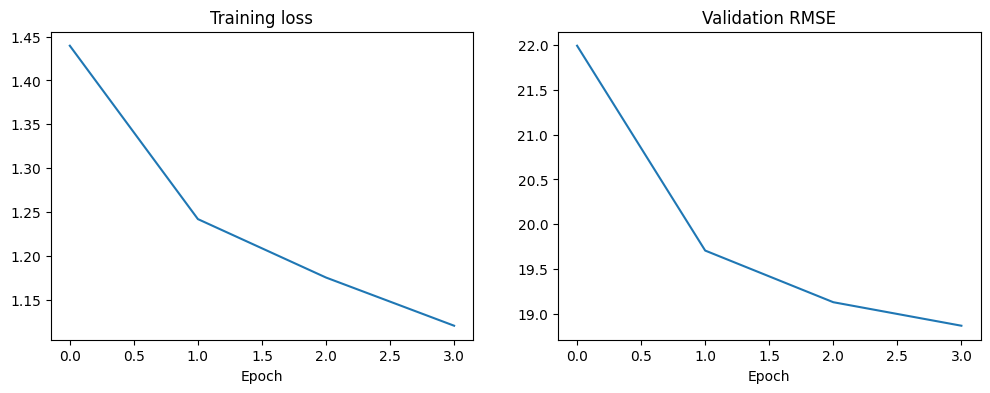

In [17]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].plot(losses)
axes[1].plot(val_rmses)
_ = axes[0].set_xlabel("Epoch")
_ = axes[1].set_xlabel("Epoch")
_ = axes[0].set_title("Training loss")
_ = axes[1].set_title("Validation RMSE")

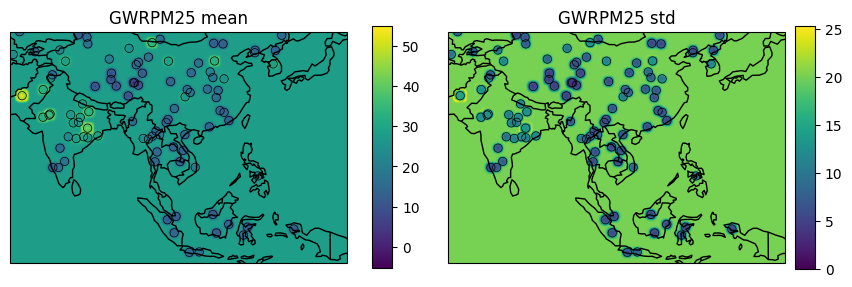

In [21]:
date = "2021-06-01"
test_task = task_loader(date, 100)
pred = model.predict(test_task, X_t=wustl)
fig = deepsensor.plot.prediction(pred, date, data_processor, task_loader, test_task, crs=ccrs.PlateCarree())